# <font color='violet'>Judging a Salon by its Yelp Cover</font>

A couple months ago, I completed my most daunting post-pandemic-first yet: I got my legs waxed for the first time since 2019. My favorite esthetician was nowhere to be found, so I searched reviews online to meet somebody new. 

I went with the salon in my city with the highest number of 5-star yelp reviews. I was anxious to get through this last 'first' and didn't seek out the advice from friends that had landed me with the true professional I'd so appreciated years ago. I put on my favorite cozy plush sweatsuit, drank some tea, and told myself that with post-pandemic uncertainty, I was making the best choice possible in a sticky situation. 

I left the salon absolutely sticky, with wax clinging to my calves and painfully pulling at my skin each time it bonded with and tore from the fuzzy fibers of my sweatpants. (For those unfamiliar with epilation: this is unusual. Even if hair removal is painful, the wax should be gone by the time a session is over.) I cursed myself all the way home for ignoring the folk wisdom that says most yelp reviews are definitely paid for. 

Now, calmer, I realize I have no idea whether all those positive reviews were paid for or if (more likely) I just had a bad experience at an otherwise decent spot. I have no easy way of knowing for sure how this dreaded salon came to appear so popular. 

The whole scenario brings to mind, however, one possible opportunity for demystifying Yelp reviews: anomoly detection.

<font color='violet'>Did my salon have similar reviews to others with comparable characteristics?</font>

If not-if my salon has significantly higher reviews than could be predicted for a business with its specific features-my suspicions may be valid!

<font color='violet'>First, I'll need to get to know what data I have available.</font>


In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from IPython.display import Audio
sound_file = './alert.wav'

In [2]:
# Load data into a dataframe
json_businesses = './yelp_business.json'
json_reviews = './yelp_review.json'

df = pd.read_json(json_businesses, lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [3]:
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [4]:
# Drop useless columns
df = df.drop(columns=['address', 'latitude', 'longitude', 'hours', 'postal_code'])

In [5]:
# Deal with missing values
df.isnull().any()

business_id     False
name            False
city            False
state           False
stars           False
review_count    False
is_open         False
attributes       True
categories       True
dtype: bool

In [6]:
# I'm just looking for salons, to analyze the relationship between their ratings and attributes.
# Drop any rows where the attributes or categories are missing.
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136601 entries, 0 to 150345
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   136601 non-null  object 
 1   name          136601 non-null  object 
 2   city          136601 non-null  object 
 3   state         136601 non-null  object 
 4   stars         136601 non-null  float64
 5   review_count  136601 non-null  int64  
 6   is_open       136601 non-null  int64  
 7   attributes    136601 non-null  object 
 8   categories    136601 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 10.4+ MB


<font color='violet'>I only care about waxing salons. Cut down the data to just businesses of interest.</font>

In [7]:
# How are categories listed?
df['categories'].unique()

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       ...,
       'Shopping, Jewelry, Piercing, Toy Stores, Beauty & Spas, Accessories, Fashion',
       'Fitness/Exercise Equipment, Eyewear & Opticians, Shopping, Sporting Goods, Bikes',
       'Beauty & Spas, Permanent Makeup, Piercing, Tattoo'], dtype=object)

In [8]:
# Isolate Beauty & Spas. But then, look to see if there is a more specific waxing category
df = df[df['categories'].str.contains('Beauty & Spas')].copy()
categories = set(df['categories'].str.split(', ').sum())
categories

{'Accessories',
 'Acne Treatment',
 'Active Life',
 'Acupuncture',
 'Addiction Medicine',
 'Adult',
 'Adult Education',
 'Adult Entertainment',
 'Advertising',
 'Aerial Fitness',
 'Aestheticians',
 'African',
 'Airports',
 'Allergists',
 'Alternative Medicine',
 'Amateur Sports Teams',
 'American (New)',
 'American (Traditional)',
 'Animal Physical Therapy',
 'Antiques',
 'Apartments',
 'Appliances',
 'Appliances & Repair',
 'Aquariums',
 'Arcades',
 'Art Classes',
 'Art Galleries',
 'Art Museums',
 'Art Supplies',
 'Arts & Crafts',
 'Arts & Entertainment',
 'Astrologers',
 'Auto Customization',
 'Auto Detailing',
 'Auto Parts & Supplies',
 'Auto Repair',
 'Automotive',
 'Ayurveda',
 'Baby Gear & Furniture',
 'Bakeries',
 'Balloon Services',
 'Barbeque',
 'Barbers',
 'Barre Classes',
 'Bars',
 'Beauty & Spas',
 'Bed & Breakfast',
 'Beer',
 'Beer Bar',
 'Bespoke Clothing',
 'Bike Rentals',
 'Bike Repair/Maintenance',
 'Bikes',
 'Bingo Halls',
 'Blow Dry/Out Services',
 'Boat Repair',
 '

In [9]:
# Waxing is a category! Isolate that. 
df = df[df['categories'].str.contains('Waxing')].copy()

# All businesses now are at least waxing spas, like mine, and my spa was *only* for waxing,
# so I can delete the categories column. 
df = df.drop(columns='categories')

df.shape

(2276, 8)

This dataset is pretty well pared down by now. Let's do some further analysis.

<font color='violet'>My salon had 4.5 stars. Is it *supposedly* above average?</font>

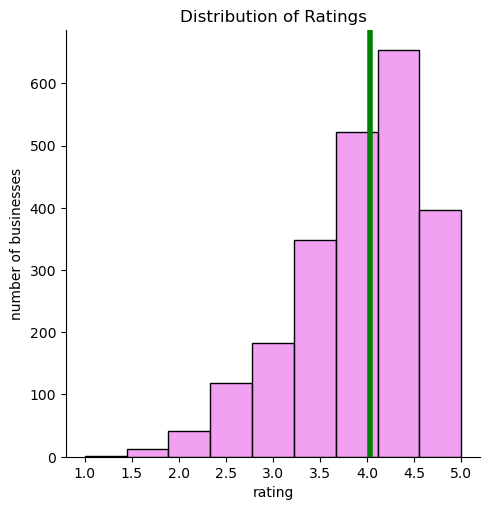

In [10]:
sns.displot(df, x = "stars", bins=9, color='violet').set(title='Distribution of Ratings', 
                                                         xlabel='rating', 
                                                         ylabel='number of businesses')
plt.axvline(x=df['stars'].mean(), color='green', linewidth=4)

<font color='violet'>Yep, I should have had an above-average experience! These scores do look pretty inflated, though. 4.0 average? Anyway, how does my salon stack up compared with other salons with similar attributes?</font>

<font color='violet'>First, I need to find out which attributes exist and find a way to easily indicate whether each business has each attribute.</font>

In [11]:
# What does the attributes column even look like? 
df['attributes'].head()

173    {'WheelchairAccessible': 'True', 'BikeParking'...
250    {'ByAppointmentOnly': 'False', 'BusinessAccept...
295    {'BikeParking': 'True', 'ByAppointmentOnly': '...
377    {'BikeParking': 'True', 'RestaurantsPriceRange...
491    {'WiFi': 'u'free'', 'RestaurantsPriceRange2': ...
Name: attributes, dtype: object

In [12]:
# Attributes are stored in dictionaries. What does one business's dictionary look like?
df.iloc[0,7]

{'WheelchairAccessible': 'True',
 'BikeParking': 'True',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
 'RestaurantsPriceRange2': '1',
 'ByAppointmentOnly': 'True',
 'BusinessAcceptsCreditCards': 'True',
 'WiFi': "u'free'"}

In [13]:
# Get a clear list of possible attributes.
attributes = []
for dictionary in df['attributes']:
    attributes.append(list(dictionary.keys()))

attributes = [item for sublist in attributes for item in sublist]
set(attributes)

{'AcceptsInsurance',
 'Alcohol',
 'Ambience',
 'BestNights',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'BusinessParking',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'DogsAllowed',
 'GoodForDancing',
 'GoodForKids',
 'HairSpecializesIn',
 'HappyHour',
 'HasTV',
 'Music',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi'}

In [14]:
# Create columns for all these attributes 
df[attributes] = np.nan
df.columns

Index(['business_id', 'name', 'city', 'state', 'stars', 'review_count',
       'is_open', 'attributes', 'WheelchairAccessible', 'BikeParking',
       'BusinessParking', 'RestaurantsPriceRange2', 'ByAppointmentOnly',
       'BusinessAcceptsCreditCards', 'WiFi', 'BusinessAcceptsBitcoin',
       'HairSpecializesIn', 'GoodForKids', 'AcceptsInsurance', 'NoiseLevel',
       'OutdoorSeating', 'DogsAllowed', 'Caters', 'RestaurantsReservations',
       'HasTV', 'CoatCheck', 'RestaurantsDelivery', 'HappyHour',
       'RestaurantsTakeOut', 'RestaurantsTableService', 'Smoking',
       'RestaurantsGoodForGroups', 'Alcohol', 'BestNights', 'GoodForDancing',
       'Ambience', 'Music'],
      dtype='object')

In [15]:
# Get row indices so I can iterate through them and fill columns with correct information.
index = df.index.values.tolist()
index[0:5]

[173, 250, 295, 377, 491]

In [16]:
for row in index:
    for key, value in df.loc[row,'attributes'].items():
        df.loc[row,key]= value

df.head()

,business_id,name,city,state,stars,review_count,is_open,attributes,WheelchairAccessible,BikeParking,...,HappyHour,RestaurantsTakeOut,RestaurantsTableService,Smoking,RestaurantsGoodForGroups,Alcohol,BestNights,GoodForDancing,Ambience,Music
173,E-nhxuu3zbt02oCj_1AFng,Selah,Tucson,AZ,5.0,60,1,"{'WheelchairAccessible': 'True', 'BikeParking'...",True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,my0bmPD5dgDFE1ia__LNlw,Nails & Beauty Lounge,Brandon,FL,3.5,84,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...",NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295,YG0OOMLP3MWYPKHpkA_mew,S&K Salon,Tucson,AZ,4.0,6,0,"{'BikeParking': 'True', 'ByAppointmentOnly': '...",True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,7qDAeIsMVj1McNktlICETw,Contempo Hair Salon,Spring Hill,FL,4.0,7,1,"{'BikeParking': 'True', 'RestaurantsPriceRange...",NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491,wRBEBZ6TvMTuwosvBa72xQ,August Pearl Salon,Nashville,TN,4.5,20,1,"{'WiFi': 'u'free'', 'RestaurantsPriceRange2': ...",True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df.iloc[0,:]

business_id                                              E-nhxuu3zbt02oCj_1AFng
name                                                                      Selah
city                                                                     Tucson
state                                                                        AZ
stars                                                                       5.0
review_count                                                                 60
is_open                                                                       1
attributes                    {'WheelchairAccessible': 'True', 'BikeParking'...
WheelchairAccessible                                                       True
BikeParking                                                                True
BusinessParking               {'garage': False, 'street': False, 'validated'...
RestaurantsPriceRange2                                                        1
ByAppointmentOnly                       

In [18]:
# Some columns still contain dictionaries. Delete them. 
df.iloc[0,[7,10]]

attributes         {'WheelchairAccessible': 'True', 'BikeParking'...
BusinessParking    {'garage': False, 'street': False, 'validated'...
Name: 173, dtype: object

In [19]:
df = df.drop(columns=df.iloc[:,[7,10]])
df.head(2)

,business_id,name,city,state,stars,review_count,is_open,WheelchairAccessible,BikeParking,RestaurantsPriceRange2,...,HappyHour,RestaurantsTakeOut,RestaurantsTableService,Smoking,RestaurantsGoodForGroups,Alcohol,BestNights,GoodForDancing,Ambience,Music
173,E-nhxuu3zbt02oCj_1AFng,Selah,Tucson,AZ,5.0,60,1,True,True,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,my0bmPD5dgDFE1ia__LNlw,Nails & Beauty Lounge,Brandon,FL,3.5,84,1,NaN,False,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Also delete columns that don't apply to waxing salons.
df.columns

Index(['business_id', 'name', 'city', 'state', 'stars', 'review_count',
       'is_open', 'WheelchairAccessible', 'BikeParking',
       'RestaurantsPriceRange2', 'ByAppointmentOnly',
       'BusinessAcceptsCreditCards', 'WiFi', 'BusinessAcceptsBitcoin',
       'HairSpecializesIn', 'GoodForKids', 'AcceptsInsurance', 'NoiseLevel',
       'OutdoorSeating', 'DogsAllowed', 'Caters', 'RestaurantsReservations',
       'HasTV', 'CoatCheck', 'RestaurantsDelivery', 'HappyHour',
       'RestaurantsTakeOut', 'RestaurantsTableService', 'Smoking',
       'RestaurantsGoodForGroups', 'Alcohol', 'BestNights', 'GoodForDancing',
       'Ambience', 'Music'],
      dtype='object')

In [21]:
df = df.drop(columns = ['RestaurantsPriceRange2', 'HairSpecializesIn', 'GoodForKids', 
                        'AcceptsInsurance', 'OutdoorSeating', 'Caters', 
                        'RestaurantsReservations', 'CoatCheck', 'RestaurantsDelivery', 
                        'HappyHour', 'RestaurantsTakeOut', 'RestaurantsTableService',
                        'RestaurantsGoodForGroups', 'GoodForDancing'])
df.columns

Index(['business_id', 'name', 'city', 'state', 'stars', 'review_count',
       'is_open', 'WheelchairAccessible', 'BikeParking', 'ByAppointmentOnly',
       'BusinessAcceptsCreditCards', 'WiFi', 'BusinessAcceptsBitcoin',
       'NoiseLevel', 'DogsAllowed', 'HasTV', 'Smoking', 'Alcohol',
       'BestNights', 'Ambience', 'Music'],
      dtype='object')

<font color='violet'>That took a minute. Now I can easily see which businesses have which attributes. But it's not so easy for the computer. These columns need to hold numbers instead of words.</font>

In [22]:
# Are there any missing values that need to be filled?
df.isnull().any()

business_id                   False
name                          False
city                          False
state                         False
stars                         False
review_count                  False
is_open                       False
WheelchairAccessible           True
BikeParking                    True
ByAppointmentOnly              True
BusinessAcceptsCreditCards     True
WiFi                           True
BusinessAcceptsBitcoin         True
NoiseLevel                     True
DogsAllowed                    True
HasTV                          True
Smoking                        True
Alcohol                        True
BestNights                     True
Ambience                       True
Music                          True
dtype: bool

In [23]:
# If a column got filled with a True/False value, 
# I can assume that a missing value should be False
bool_cols = []
for column in df.columns:
    if 'False' in df[column].unique():
        bool_cols.append(column) 
bool_cols

/var/folders/xz/sq63wkqx22q0t_hr7_1jfrhr0000gn/T/ipykernel_8427/1956958666.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'False' in df[column].unique():


['WheelchairAccessible',
 'BikeParking',
 'ByAppointmentOnly',
 'BusinessAcceptsCreditCards',
 'BusinessAcceptsBitcoin',
 'DogsAllowed',
 'HasTV']

In [24]:
df[bool_cols] = df[bool_cols].fillna('False')
df.isna().any()

business_id                   False
name                          False
city                          False
state                         False
stars                         False
review_count                  False
is_open                       False
WheelchairAccessible          False
BikeParking                   False
ByAppointmentOnly             False
BusinessAcceptsCreditCards    False
WiFi                           True
BusinessAcceptsBitcoin        False
NoiseLevel                     True
DogsAllowed                   False
HasTV                         False
Smoking                        True
Alcohol                        True
BestNights                     True
Ambience                       True
Music                          True
dtype: bool

In [25]:
# Figure out what's up with the rest of the columns that have mussing values.
print('Alcohol: ', df['Alcohol'].unique())
print('Smoking: ', df['Smoking'].unique())
print('BestNights: ', df['BestNights'].unique())
print('NoiseLevel: ', df['NoiseLevel'].unique())
print('WiFi: ', df['WiFi'].unique())
print('Ambience: ', df['Ambience'].unique())
print('Music: ', df['Music'].unique())

Alcohol:  [nan "u'full_bar'" "'none'"]
Smoking:  [nan "u'outdoor'" "u'no'" "'outdoor'" "'no'"]
BestNights:  [nan
 "{'monday': False, 'tuesday': True, 'friday': False, 'wednesday': True, 'thursday': True, 'sunday': False, 'saturday': False}"]
NoiseLevel:  [nan "u'very_loud'" "u'average'" "u'quiet'"]
WiFi:  ["u'free'" nan "u'no'" "u'paid'" "'free'" "'no'" 'None']
Ambience:  [nan
 "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}"
 "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': True, 'classy': False, 'casual': False}"]
Music:  [nan
 "{'dj': False, 'background_music': True, 'jukebox': False, 'live': False, 'video': False, 'karaoke': False}"
 "{'dj': False, 'background_music': False, 'no_music': False, 'jukebox': False, 'live': False, 'video': False, 'karaoke': False}"]


In [26]:
# Missed deleting some columns with dictionaries. 
df = df.drop(columns=['BestNights','Ambience','Music'])
df.columns

Index(['business_id', 'name', 'city', 'state', 'stars', 'review_count',
       'is_open', 'WheelchairAccessible', 'BikeParking', 'ByAppointmentOnly',
       'BusinessAcceptsCreditCards', 'WiFi', 'BusinessAcceptsBitcoin',
       'NoiseLevel', 'DogsAllowed', 'HasTV', 'Smoking', 'Alcohol'],
      dtype='object')

In [27]:
# And the options for Alcohol and Smoking make them seem unapplicable to waxing salons
df = df.drop(columns=['Alcohol', 'Smoking'])

In [28]:
# Deal with the other columns that have null values: Wifi and NoiseLevel
# For Wifi, missing values can just get turned into 0. Other categories should be come numbers.
df['WiFi'] = df['WiFi'].fillna(0)
df['WiFi'] = df['WiFi'].replace({"u'free'":2, "u'no'":0, "u'paid'":1, "'free'":2, "'no'":0,
                                'None':0})
df['WiFi'].unique()

array([2, 0, 1])

In [29]:
# Fill in missing values of the NoiseLevel column with the average, after changing 
# levels to numeric quantities. 
df['NoiseLevel'] = df['NoiseLevel'].replace({"u'very_loud'":3, "u'average'":2, "u'quiet'":1})
df['NoiseLevel'] = df['NoiseLevel'].fillna(round(df['NoiseLevel'].mean()))
df['NoiseLevel'].unique()

array([1., 3., 2.])

In [30]:
# Replace "True" with 1 and "False" with 0 in all the columns where these appear
df = df.replace({'True':1, 'False':0})
df.head(2)

,business_id,name,city,state,stars,review_count,is_open,WheelchairAccessible,BikeParking,ByAppointmentOnly,BusinessAcceptsCreditCards,WiFi,BusinessAcceptsBitcoin,NoiseLevel,DogsAllowed,HasTV
173,E-nhxuu3zbt02oCj_1AFng,Selah,Tucson,AZ,5.0,60,1,1,1,1,1,2,0,1.0,0,0
250,my0bmPD5dgDFE1ia__LNlw,Nails & Beauty Lounge,Brandon,FL,3.5,84,1,0,0,0,1,0,0,1.0,0,0


In [31]:
df.isnull().any()

business_id                   False
name                          False
city                          False
state                         False
stars                         False
review_count                  False
is_open                       False
WheelchairAccessible          False
BikeParking                   False
ByAppointmentOnly             False
BusinessAcceptsCreditCards    False
WiFi                          False
BusinessAcceptsBitcoin        False
NoiseLevel                    False
DogsAllowed                   False
HasTV                         False
dtype: bool

In [32]:
df.dtypes

business_id                    object
name                           object
city                           object
state                          object
stars                         float64
review_count                    int64
is_open                         int64
WheelchairAccessible            int64
BikeParking                     int64
ByAppointmentOnly               int64
BusinessAcceptsCreditCards      int64
WiFi                            int64
BusinessAcceptsBitcoin          int64
NoiseLevel                    float64
DogsAllowed                    object
HasTV                           int64
dtype: object

In [33]:
# DogsAllowed had no missing values but still needs to be made numeric
df['DogsAllowed'].unique()

array([0, 1, 'None'], dtype=object)

In [34]:
df['DogsAllowed'] = df['DogsAllowed'].replace('None',0)

<font color='violet'>Now I can check out which attributes might be associated with high stars.</font>

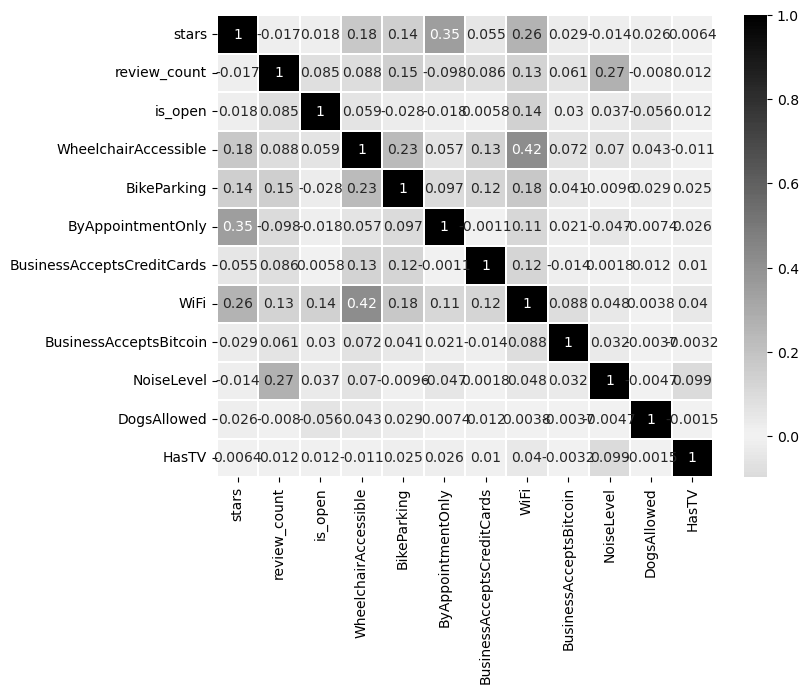

In [35]:
plt.figure(figsize=(8,6))
cmap = sns.diverging_palette(h_neg=0, h_pos=0, s=0, l=0, as_cmap=True)
sns.heatmap(df.corr(), linewidths=.1, cmap=cmap, center=0.0, annot=True)
plt.yticks(rotation=0);

<font color='violet'>It looks like attribute most correlated with the number of stars are ByAppointmentOnly, WiFi, WheelchairAccessible, and BikeParking. How big of a difference does it make whether these categories are true or false?</font>

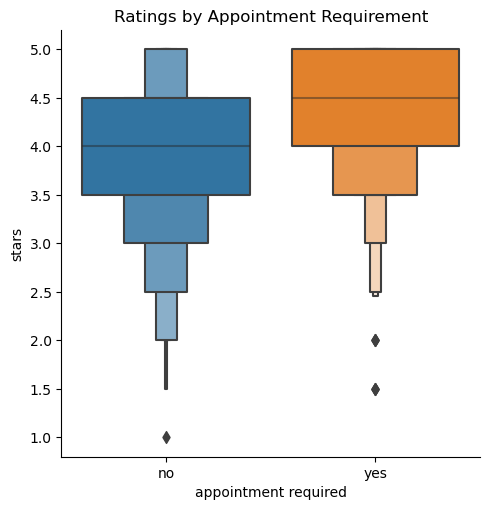

In [36]:
ax = sns.catplot(data=df, x="ByAppointmentOnly", y="stars", kind="boxen").set(
    title='Ratings by Appointment Requirement', xlabel='appointment required', ylabel='stars')
ax.set_xticklabels(['no', 'yes']);

<font color='violet'>My salon allows walk-ins. Similar salons have a score of 4, not 4.5!font>

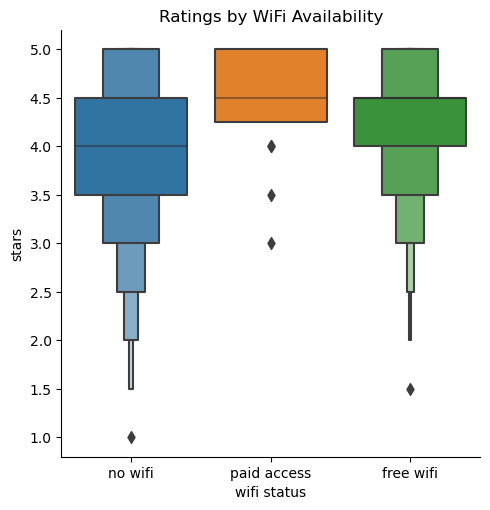

In [37]:
ax = sns.catplot(data=df, x="WiFi", y="stars", kind="boxen").set(
    title='Ratings by WiFi Availability', xlabel='wifi status', ylabel='stars')
ax.set_xticklabels(['no wifi', 'paid access', 'free wifi']);

<font color='violet'>My salon did not offer wifi. Again, the lowest category!font>

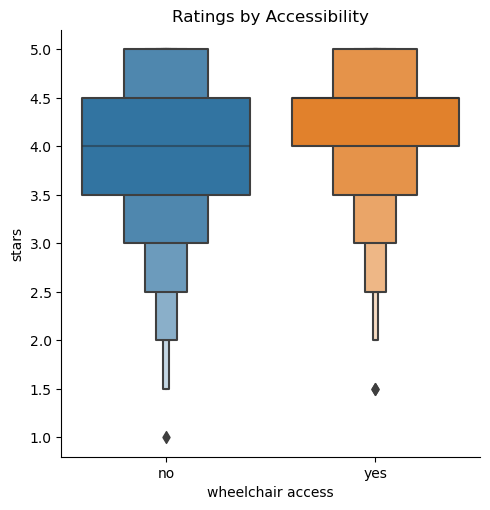

In [38]:
ax = sns.catplot(data=df, x="WheelchairAccessible", y="stars", kind="boxen").set(
    title='Ratings by Accessibility', xlabel='wheelchair access', ylabel='stars')
ax.set_xticklabels(['no', 'yes']);

<font color='violet'>My salon was wheelchair accessible. It had ought to be!<font>

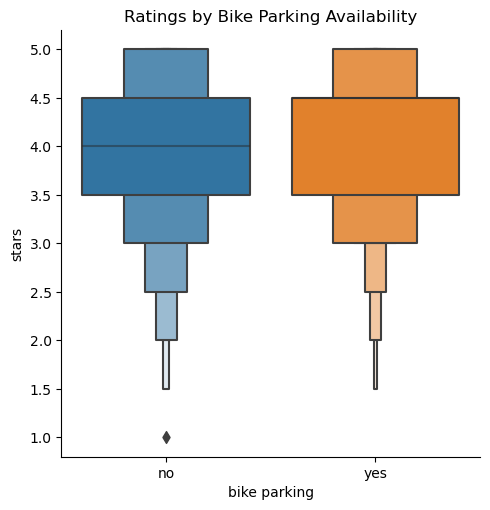

In [39]:
ax = sns.catplot(data=df, x="BikeParking", y="stars", kind="boxen").set(
    title='Ratings by Bike Parking Availability', xlabel='bike parking', ylabel='stars')
ax.set_xticklabels(['no', 'yes']);

My salon did have bike parking, which sets it a bit ahead of the rest. But we're getting into pretty irrelevant territory here; it hardly makes a difference whether a salon has bike parking or not! 

It's looking like my salon doesn't live up to its 4.5 star rating when evaluated on key attributes that set high-scoring business apart. But am I just interpreting the graphs the way I want to see them? How can I know for sure? 

<font color='violet'>Create a model to predict what the score of my salon would be if nothing suspicious is going on and it's not an anomoly<font>

In [40]:
# Before a computer model can make predictions, 100% of columns must be numeric
# The business ID and name won't be helpful at all in making predictions; delete them.
df = df.drop(columns=['business_id', 'name'])

Next, the city and state columns need to be encoded (turned into numbers). But if Oakland isn't even one of the cities listed, just drop the cities column because it will be useless for making comparisons. 

In [41]:
df['city'].str.contains('Oakland').any()

False

In [42]:
df = df.drop(columns='city')

In [43]:
# Encode states
ler = LabelEncoder().fit(df['state'])
df['state']=ler.transform(df['state'])
dico = dict(zip(ler.classes_, ler.transform(ler.classes_)))
df['state'].unique()

array([ 1,  4, 13,  7,  8, 10, 12,  3,  0, 11,  2,  9,  6,  5])

In [44]:
dico

{'AB': 0,
 'AZ': 1,
 'CA': 2,
 'DE': 3,
 'FL': 4,
 'ID': 5,
 'IL': 6,
 'IN': 7,
 'LA': 8,
 'MO': 9,
 'NJ': 10,
 'NV': 11,
 'PA': 12,
 'TN': 13}

In [45]:
df.head()

,state,stars,review_count,is_open,WheelchairAccessible,BikeParking,ByAppointmentOnly,BusinessAcceptsCreditCards,WiFi,BusinessAcceptsBitcoin,NoiseLevel,DogsAllowed,HasTV
173,1,5.0,60,1,1,1,1,1,2,0,1.0,0,0
250,4,3.5,84,1,0,0,0,1,0,0,1.0,0,0
295,1,4.0,6,0,1,1,0,1,0,0,1.0,0,0
377,4,4.0,7,1,0,1,1,1,2,0,1.0,0,0
491,13,4.5,20,1,1,0,0,1,2,0,1.0,0,0


In [46]:
# A random forest model will be simplest, but first the 'stars' column needs to be whole numbers
df['stars'] = (df['stars']*2).astype(int)
df['stars'].dtype

dtype('int64')

In [47]:
df['stars'].unique()

array([10,  7,  8,  9,  6,  5,  4,  3,  2])

In [48]:
# Get train and test sets for modeling
X = df.drop(columns='stars')
y = df['stars']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Model the data and see how the model scores
rf = RandomForestClassifier(random_state=43)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
metrics.f1_score(y_test, y_pred, average='micro')

0.2869692532942899

<font color='violet'>The moment of truth has arrived. I created a model (not a particularly good one, but fine for my purposes here), and now I can use it to predict what my salon's rating *should* be.<font>

In [49]:
# Create a tiny dataset with just details about my salon. What should my dataframe look like?
X_test.head(1)

,state,review_count,is_open,WheelchairAccessible,BikeParking,ByAppointmentOnly,BusinessAcceptsCreditCards,WiFi,BusinessAcceptsBitcoin,NoiseLevel,DogsAllowed,HasTV
99461,5,85,1,0,0,0,1,0,0,1.0,0,0


In [50]:
X_mine = pd.DataFrame({'state':[2], 'review_count':[214], 'is_open':[1], 
                       'WheelchairAccessible':[1], 'BikeParking':[1], 'ByAppointmentOnly':[0], 
                       'BusinessAcceptsCreditCards':[1], 'WiFi':[0], 
                       'BusinessAcceptsBitcoin':[0], 'NoiseLevel':[0], 'DogsAllowed':[0],
                       'HasTV':[0]})
X_mine 

,state,review_count,is_open,WheelchairAccessible,BikeParking,ByAppointmentOnly,BusinessAcceptsCreditCards,WiFi,BusinessAcceptsBitcoin,NoiseLevel,DogsAllowed,HasTV
0,2,214,1,1,1,0,1,0,0,0,0,0


In [51]:
# Make the prediction! Remember to divide the result by 2 for my salon's "real" score
my_pred = rf.predict(X_mine)
my_pred

array([7])

<font color='violet'>Yikes. My salon would be predicted to get a score of 4.5 given its attributes. Maybe the stories I've heard about how Yelp already does anomoly detection are true, and this salon didn't buy their reviews. I think the moral of the story is that I can definitively conclude the salon is homophobic.<font>